In [1]:
# general
from __future__ import print_function, division
import os
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from datetime import datetime

import GPUtil

# torch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import random_split

from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences

import torch.nn as nn
import torchvision.models as models
from pytorch_pretrained_bert import BertModel
from transformers import DistilBertModel
import torch.nn.functional as F

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords

Using TensorFlow backend.


In [2]:
# Reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic=True

In [3]:
# Parameters
EPOCHS=10
BATCH_SIZE_TRAIN=8 # 4 if grad for all paramters
BATCH_SIZE_VALID=3

train_split = 0.8

token_length = 96

n_hidden = 100

LR = 1e-5
lr_decay = 0.9

### Structure
- plot images
- text preprocessing
- data loader
- image augmentation

### Plot images

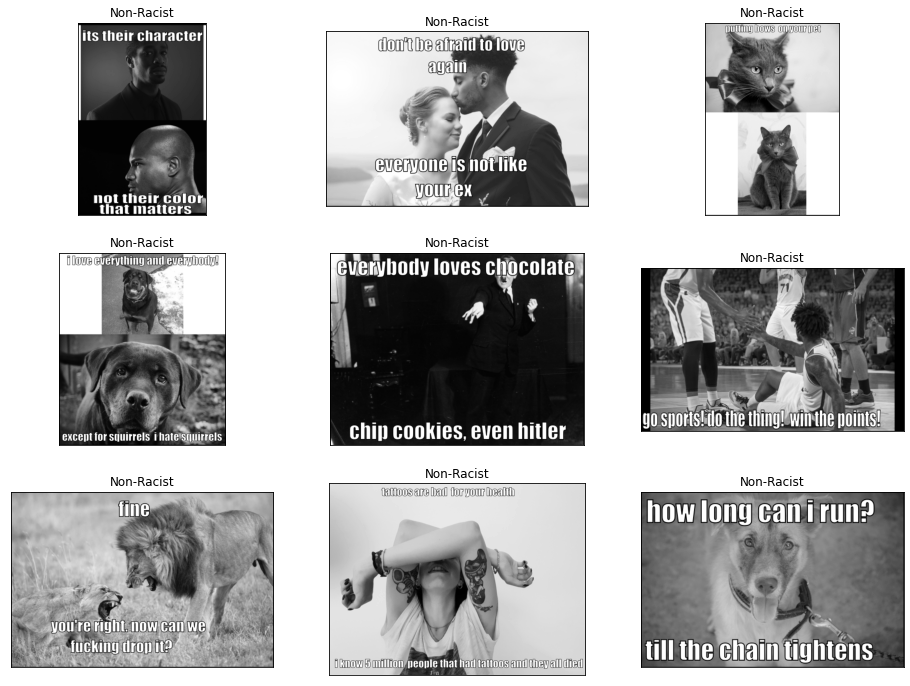

In [4]:
dataset_df = pd.read_json('../data/train.jsonl', lines=True)

# plot a few images together with labels
nx = 3
ny = 3

fig, ax = plt.subplots(figsize=(16, ny*4), nrows=ny, ncols=nx)
for i in range(ny):
    for j in range(nx):
        img_id = dataset_df['id'].values[i*nx+ j]
        
        # catch trailing 0
        if img_id < 1e4:
            img = cv2.imread('../data/img/0'+str(img_id)+ '.png', cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread('../data/img/'+str(img_id)+ '.png', cv2.IMREAD_GRAYSCALE)  
        
        # plot and remove axes
        ax[i,j].imshow(img, cmap='gray')
        ax[i,j].set_title('Racist' if dataset_df['label'].values[i*nx+ j] else 'Non-Racist')
        ax[i,j].axes.get_xaxis().set_visible(False)
        ax[i,j].axes.get_yaxis().set_visible(False)
        
plt.show()

### Text Preprocessing

Bert requires: <br>
- tokenization
- special characters
- padding
- mask

techniques to try (for other models): <br>
- Lower casing
- Punctuation removal
- Stopwords removal
- Frequent words removal
- Rare words removal
- Spelling correction
- Tokenization
- Stemming
- Lemmatization
- word embedding/ bag of words

In [5]:
# dictionary
data = dataset_df.to_dict(orient='records') # have been shuffled in previous step

# Calculate the number of samples to include in each set.
train_size = int(train_split * len(data))
val_size = len(data) - train_size

# train valid split
train_data, valid_data = random_split(data, [train_size, val_size])

#train_size = int(0.05 * len(valid_data))
#val_size = len(valid_data) - train_size
#valid_data, _ = random_split(valid_data, [train_size, val_size])

In [6]:
# split into text (input) and labels (output)
train_texts, train_imgs, train_labels = list(zip(*map(lambda d: (d['text'], d['img'], d['label']), train_data)))
valid_texts, valid_imgs, valid_labels = list(zip(*map(lambda d: (d['text'], d['img'], d['label']), valid_data)))

len(train_texts), len(train_labels), len(valid_texts), len(valid_labels)

(6800, 6800, 1700, 1700)

In [7]:
# class imbalance
print(sum(train_labels)/ len(train_labels))
print(sum(valid_labels)/ len(valid_labels))

0.35573529411764704
0.3711764705882353


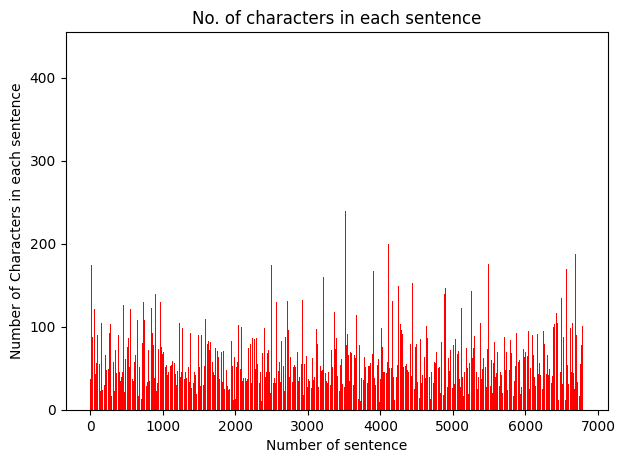

In [8]:
# analysis of review length
sentences = [len(sent) for sent in train_texts]
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,len(train_texts)+1), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

# -> bert with 64 tokens should be sufficient

In [9]:
# bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [10]:
# token embeddings with required separation token
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:token_length-2] + ['[SEP]'], train_texts))
valid_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:token_length-2] + ['[SEP]'], valid_texts))

len(train_tokens), len(valid_tokens)

(6800, 1700)

In [11]:
# to be deleted -> SYNONYMES
print(train_tokens[0])
synonyme_idx = np.unique(np.random.randint(1, train_tokens[0].index('[SEP]'), int(0.2*train_tokens[0].index('[SEP]'))))
print([train_tokens[0][idx] for idx in synonyme_idx])
# remove stopwords and punctation
synonyme_idx = [idx for idx in synonyme_idx if not train_tokens[0][idx] in stopwords.words()]
synonyme_idx = [idx for idx in synonyme_idx if train_tokens[0][idx].isalnum()]

# find synonyms of words to be masked
replace_words = [train_tokens[0][idx] for idx in synonyme_idx] # don't use stopwords


print(replace_words)
synonymes = [wordnet.synsets(word) for word in replace_words]
synonyme_idx = [synonyme_idx[i] for i in range(len(synonymes)) if synonymes[i]!=[]]
synonymes = [synonymes[i] for i in range(len(synonymes)) if synonymes[i]!=[]]
print(synonyme_idx)

# replace words by synonyms
for i_syn, i_sen in enumerate(synonyme_idx):
    train_tokens[0][i_sen] = np.random.choice(synonymes[i_syn]).lemmas()[0].name()

print(train_tokens[0])

['[CLS]', 'that', 'look', 'when', 'you', 'find', 'out', 'your', 'husband', 'isn', "'", 't', 'coming', 'home', 'from', 'the', 'mosque', '[SEP]']
['out', 'home', 'mosque']
['home', 'mosque']
[13, 16]
['[CLS]', 'that', 'look', 'when', 'you', 'find', 'out', 'your', 'husband', 'isn', "'", 't', 'coming', 'home', 'from', 'the', 'mosque', '[SEP]']


In [12]:
# put everything back into a dictionary
data_train = {'img_names': train_imgs, 'tokens': train_tokens, 'labels': train_labels}

data_valid = {'img_names': valid_imgs, 'tokens': valid_tokens, 'labels': valid_labels}

## Dataloader

In [13]:
class HatefulMemesDataset(Dataset):
    """ Hateful Memes dataset """
    
    def __init__(self, data, img_dir, normalize=False, synonyme=False, transform=None):
        """
        Args:
            df_path (string): path to jsonl file with image id's
            root_dir (string): directory with all the images
            transform (callable): optional transform to be applied on a sample
        """
        # text
        self.data = data
        
        # image
        self.img_dir = img_dir
        self.normalize = normalize
        self.transform = transform
        self.synonyme = synonyme
        
    def __len__(self):
        return len(self.data['labels'])
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx_tolist()
            
            
        data_train = {'img_names': train_imgs, 'tokens': train_tokens, 'labels': train_labels}
        
        # load image ------------------------------------
        img_name = os.path.join(self.img_dir, str(self.data['img_names'][idx]))
        image = cv2.imread(img_name)
        #image = image.astype(np.float)/ 255.0
        
        # label ------------------------------------------
        label = self.data['labels'][idx]
        label = np.array([label])
        label = label.astype('int').reshape(-1)
        
        # token -------------------------------------------
        token = self.data['tokens'][idx]
        
        # add variance by synonyms
        if self.synonyme:
            synonyme_idx = np.unique(np.random.randint(1, token.index('[SEP]'), int(0.1*token.index('[SEP]'))))
            # remove stopwords and punctation
            synonyme_idx = [idx for idx in synonyme_idx if not token[idx] in stopwords.words()]
            synonyme_idx = [idx for idx in synonyme_idx if token[idx].isalnum()]

            # find synonyms of words to be masked
            replace_words = [token[idx] for idx in synonyme_idx] # don't use stopwords
            synonymes = [wordnet.synsets(word) for word in replace_words]
            synonyme_idx = [synonyme_idx[i] for i in range(len(synonymes)) if synonymes[i]!=[]]
            synonymes = [synonymes[i] for i in range(len(synonymes)) if synonymes[i]!=[]]

            # replace words by synonyms
            for i_syn, i_sen in enumerate(synonyme_idx):
                token[i_sen:i_sen+1] = tokenizer.tokenize(np.random.choice(synonymes[i_syn]).lemmas()[0].name())
        
        # prepare token ids: each token (word fragment) corresponds to an id in the bert corpus
        # further need to make all review the same length -> padding too short, truncating too long ones
        token_id = pad_sequences([tokenizer.convert_tokens_to_ids(token)], maxlen=token_length, truncating="post", padding="post", dtype="int")
        token_id = token_id.reshape(-1)
        
        # mask for padding -> required by bert
        mask = [float(i > 0) for i in token_id]
        mask = np.array([mask])
        mask = mask.astype('float').reshape(-1)
        
        #
        sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample

0 (533, 800, 3) (1,)
1 (400, 236, 3) (1,)
2 (533, 800, 3) (1,)
3 (800, 572, 3) (1,)


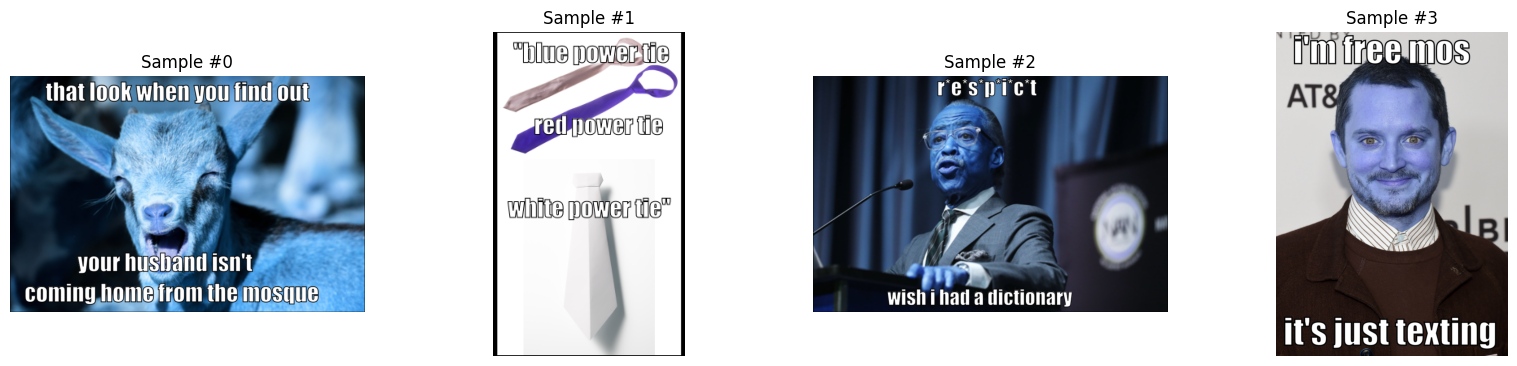

In [14]:
memes_dataset = HatefulMemesDataset(data_train, img_dir='../data', normalize=False)

fig = plt.figure(figsize=(16, 4))

for i in range(len(memes_dataset)):
    sample = memes_dataset[i]

    print(i, sample['image'].shape, sample['label'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    #ax.set_xlabel(sample['text'])
    #print(sample['token'])
    ax.axis('off')
    
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

0 (533, 800, 3) (1,)
1 (400, 236, 3) (1,)
2 (533, 800, 3) (1,)
3 (800, 572, 3) (1,)


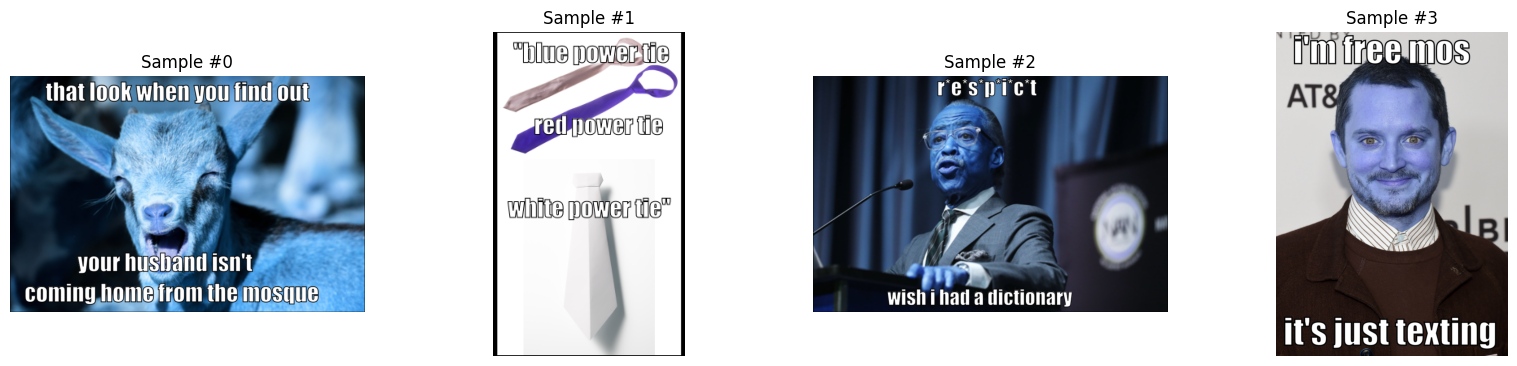

In [15]:
memes_dataset = HatefulMemesDataset(data_train, img_dir='../data', synonyme=True, normalize=False)

fig = plt.figure(figsize=(16, 4))

for i in range(len(memes_dataset)):
    sample = memes_dataset[i]

    print(i, sample['image'].shape, sample['label'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    #ax.set_xlabel(sample['text'])
    #print(sample['token'])
    ax.axis('off')
    
    plt.imshow(sample['image'])

    if i == 3:
        plt.show()
        break

## Image augmentation

In [16]:
# aspect ratio = 1.3 (width / height) median
# image dimensions = 128 x 128 (16k pixels) for CNN's

class Rescale(object):
    """Rescale the image in a sample to a given size
    Args:
        img_width (int): desired width of image
        max_distortion (float): maximum distortion of an image in a given direction
    """
    
    def __init__(self, size, max_distortion):
        self.size = size
        self.max_distortion = max_distortion
        
    def __call__(self, sample):
        image, token_id, mask, label = sample['image'], sample['token_id'], sample['mask'], sample['label']

        #
        width, height = image.shape[:2]
        aspect_ratio = width/ height
        
        # resulting distortion too high -> padding
        if aspect_ratio > self.max_distortion:
            pad = width- 2*height
            img = cv2.copyMakeBorder(image, int(pad/2.), int(pad/2.), 0, 0, cv2.BORDER_CONSTANT)
        elif 1./aspect_ratio > self.max_distortion:
            pad = height- 2*width
            img = cv2.copyMakeBorder(image, 0, 0, int(pad/2.), int(pad/2.), cv2.BORDER_CONSTANT)
        else:
            img = image.copy()
            
        # resize image
        #img = img.astype(np.float)
        img = transform.resize(img, (self.size, self.size))
        
        return {'image': img, 'token_id': token_id, 'mask': mask, 'label': label}

In [17]:
# cropping, scaling, rotation, noise, color?
class Transform(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self):
        pass
        
    def __call__(self, sample):
        image, token_id, mask, label = sample['image'], sample['token_id'], sample['mask'], sample['label']
        
        transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.RandomRotation(degrees=(-20, 20)),
                                        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
        
        
        # need to get to [0, 255] for ToPILImage
        img = (255.* image).astype(np.uint8)
        img = transform(img)
        #img = img.float()/ 255.
        
        
        # TODO: use normalization as required by pretrained models
        #normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                                 std=[0.229, 0.224, 0.225])
        

        return {'image': img,'token_id': token_id, 'mask': mask, 'label': label}

In [18]:
# cropping, scaling, rotation, noise, color?
class Norm(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self):
        pass
        
    def __call__(self, sample):
        image, token_id, mask, label = sample['image'], sample['token_id'], sample['mask'], sample['label']
        
        transform = transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
        
        
        # need to get to [0, 255] for ToPILImage
        img = (255.* image).astype(np.uint8)
        img = transform(img)

        return {'image': img,'token_id': token_id, 'mask': mask, 'label': label}

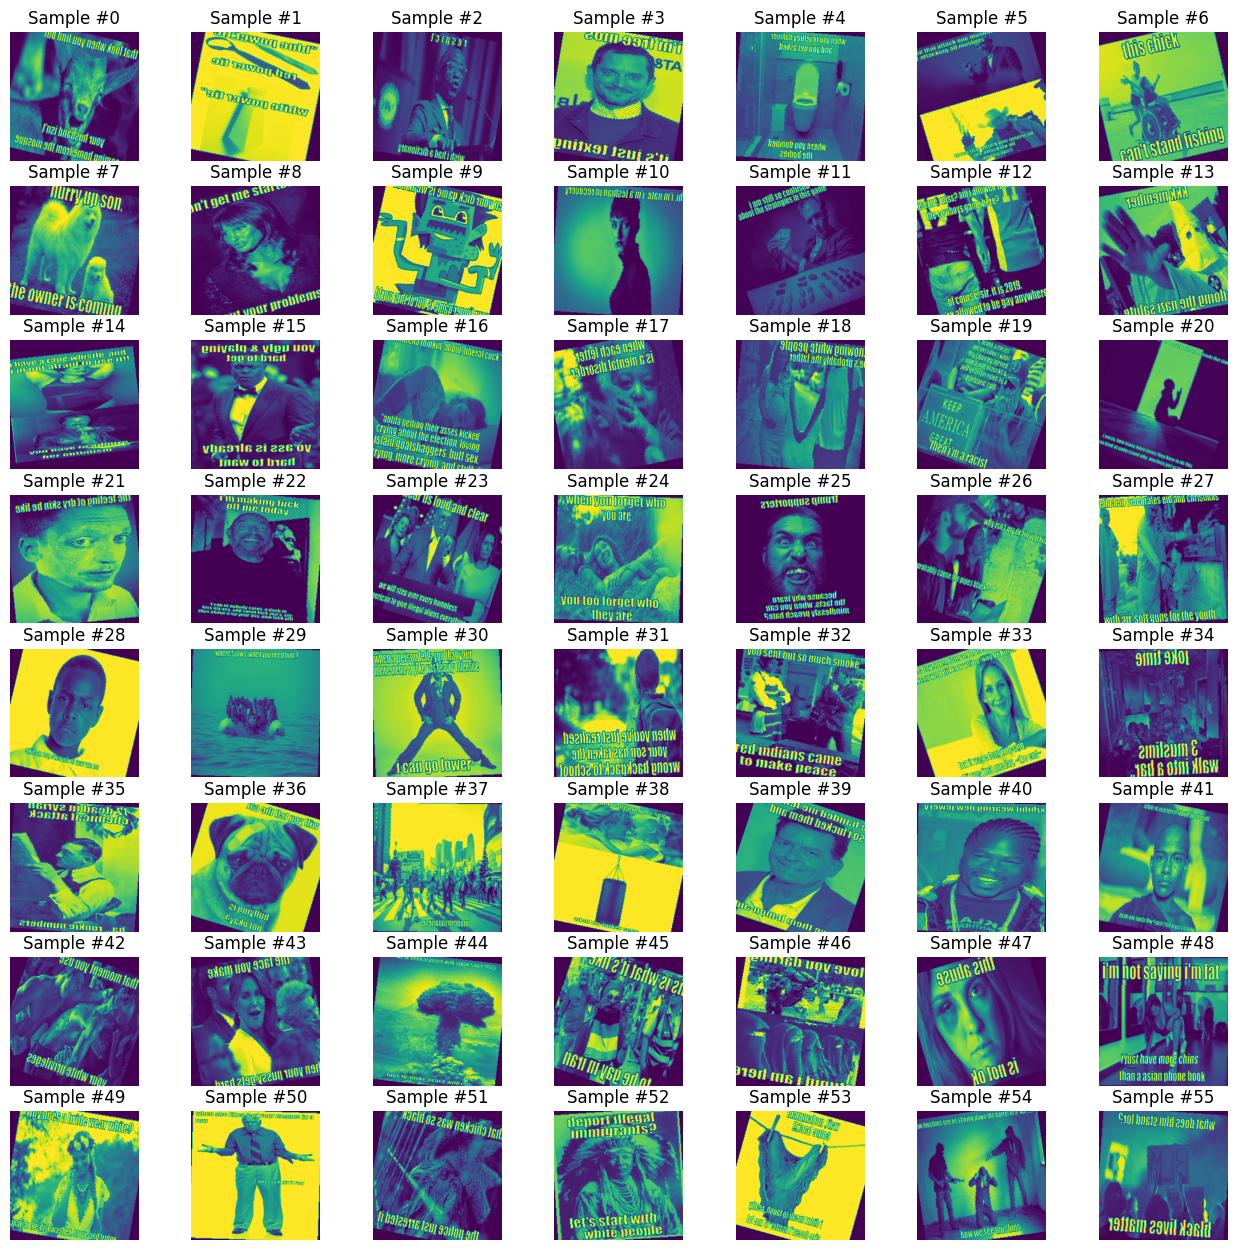

In [19]:
# dataset
composed = transforms.Compose([Rescale(224, 2.),
                               Transform()])

memes_dataset = HatefulMemesDataset(data_train, img_dir='../data',
                                    normalize=False, transform=composed)

#plots
ncols = 7
nrows = 8
fig, ax = plt.subplots(figsize=(16, 16), ncols=ncols, nrows=nrows)

for i in range(ncols*nrows):
    x = i%ncols 
    y = int(i/ncols)
    
    sample = memes_dataset[i]

    ax[y,x].imshow(sample['image'][0]) # take 0th channel
    ax[y,x].set_title('Sample #{}'.format(i))
    ax[y,x].axis('off')

plt.show()

## Model 

In [20]:
# https://discuss.pytorch.org/t/combining-trained-models-in-pytorch/28383/2
class MyEnsemble(nn.Module):
    def __init__(self, n_hidden):
        super(MyEnsemble, self).__init__()
        # pretrained models
        self.modelVision = models.densenet121(pretrained=True)
        self.modelNLP = BertModel.from_pretrained('bert-base-cased')
        
        # freeze weights
        for param in self.modelNLP.parameters():
            param.requires_grad = False
            
        for param in self.modelVision.features.parameters():
            param.requires_grad = False
        
        # give densenet an untrained classifier layer
        #self.modelVision.classifier = nn.Linear(1024, 1000)
        self.modelVision.classifier = nn.Identity()
        
        # classifier layer
        self.dropout1 = torch.nn.Dropout(p=0.2)
        self.classifier11 = nn.Linear(768+ 1024, n_hidden)
        self.dropout2 = torch.nn.Dropout(p=0.2)
        self.classifier22 = nn.Linear(n_hidden, 1)
        
    def forward(self, imgs, tokens, masks):
        # vision
        x1 = F.relu(self.modelVision(imgs)) # to complete the new classifier layer with a nonlinearity
        
        # Bert is such that the first token contains all info for classification
        _, x2 = self.modelNLP(tokens, attention_mask=masks, output_all_encoded_layers=False)
        
        # TODO: dropout needed?
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.classifier11(x))
        y = torch.sigmoid(self.classifier22(x))
        
        return y

In [21]:
# allocate on gpu
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

model = MyEnsemble(n_hidden).to(device)
print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

GPUtil.showUtilization()

print(sum(p.numel() for p in model.parameters()))
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

463.003648M
| ID | GPU | MEM |
------------------
|  0 | 26% | 23% |
115443529
179401


In [22]:
class Pretrained(nn.Module):
    def __init__(self):
        super(Pretrained, self).__init__()
        # pretrained models
        self.modelNLP = BertModel.from_pretrained('bert-base-cased')
        
        # classifier layer
        self.layernorm1 = torch.nn.LayerNorm(768)
        self.classifier1 = nn.Linear(768, 3)
        self.dropout = torch.nn.Dropout(p=0.5)
        
    def forward(self, tokens, masks):
        # Bert is such that the first token contains all info for classification
        _, x2 = self.modelNLP(tokens, attention_mask=masks, output_all_encoded_layers=False)
        #x = self.layernorm1(x2)
        x = self.dropout(x2)
        y = self.classifier1(x)
        
        return y

pretrained_model = Pretrained()
pretrained_model.load_state_dict(torch.load('../models/07-24-10-2020'))
pretrained_dict = pretrained_model.state_dict()

# Initialize model
model_dict = model.state_dict()

# Fiter out unneccessary keys
filtered_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
model_dict.update(filtered_dict)
model.load_state_dict(model_dict)

<All keys matched successfully>

In [23]:
'''
print("Optimizer's state_dict:")
for var_name in model_dict:
    print(var_name)
    #print(var_name, "\t", model_dict[var_name])
    '''

'\nprint("Optimizer\'s state_dict:")\nfor var_name in model_dict:\n    print(var_name)\n    #print(var_name, "\t", model_dict[var_name])\n    '

In [24]:
'''
print("Optimizer's state_dict:")
for var_name in pretrained_dict:
    print(var_name)
    #print(var_name, "\t", model_dict[var_name])
'''

'\nprint("Optimizer\'s state_dict:")\nfor var_name in pretrained_dict:\n    print(var_name)\n    #print(var_name, "\t", model_dict[var_name])\n'

In [25]:
from torch.optim import Adam
# TODO: not sure if this does what I think it should do
# optimizer
param_optimizer = list(model.modelVision.classifier.named_parameters())
param_optimizer += list(model.classifier11.named_parameters())
param_optimizer += list(model.classifier22.named_parameters())
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = Adam(model.parameters(), lr=LR, eps=1e-8) # TODO: SGD for just the final classifier

In [26]:
print([p[1].size() for p in param_optimizer])

[torch.Size([100, 1792]), torch.Size([100]), torch.Size([1, 100]), torch.Size([1])]


In [27]:
'''
bert = BertModel.from_pretrained('bert-base-uncased')
for name, child in bert.named_children():
    print(name)
    for param in child.parameters():
            print(param.shape)
'''

"\nbert = BertModel.from_pretrained('bert-base-uncased')\nfor name, child in bert.named_children():\n    print(name)\n    for param in child.parameters():\n            print(param.shape)\n"

In [28]:
def weighted_binary_cross_entropy(output, target, weights=None):
        
    if weights is not None:        
        # TODO: should work since target = {0, 1}, thus sets weights to zero if not needed
        loss = weights * (target * torch.log(output)) + \
               weights * ((1 - target) * torch.log(1 - output))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

    return torch.neg(torch.mean(loss))

In [29]:
from datetime import date
# summary writer
log_dir = './summaries/summary'+ datetime.now().strftime('%H-%d-%m-%Y')
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir)

## Training

In [30]:
### from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import roc_auc_score
from transformers import get_linear_schedule_with_warmup
from torch.optim import lr_scheduler

# training
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

# dataset
composed = transforms.Compose([Rescale(224, 2.), Transform()])

# training
train_dataset = HatefulMemesDataset(data_train, img_dir='../data',
                                    normalize=False, synonyme=True, transform=composed)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, num_workers=1, shuffle=True)


# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_loader) * EPOCHS

# Create the learning rate scheduler.
#scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                            num_warmup_steps = 1000, 
#                                            num_training_steps = total_steps)
#scheduler = lr_scheduler.CosineAnnealingLR(optimizer, int(total_steps/5), eta_min=1e-5)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1.0)

print(scheduler.get_lr())

composed = transforms.Compose([Rescale(224, 2.), Norm()])

# validation
valid_dataset = HatefulMemesDataset(data_valid, img_dir='../data',
                                    normalize=False, transform=composed)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE_VALID, shuffle=False)

# binary cross entropy loss (classification)
loss_func = nn.BCELoss()

# monitor train progress
stats = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': [], 'val_rocauc': []}

time_tot = []

for epoch_num in range(EPOCHS):
    #
    train_loss = 0.
    train_correct = 0.
    
    valid_loss = 0.
    valid_correct = 0.
    
    # training
    model.train()
    
    # unfreeze weights
    if epoch_num > EPOCHS -3:
        for param in model.modelNLP.parameters():
            param.requires_grad = True
            
        for param in model.modelVision.features.parameters():
            param.requires_grad = True
            
        # Not sure if this is necessary (at least should not be harmful)
        optimizer = Adam(model.parameters(), lr=1e-5) # lr=LR
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 1.0)
        
        # not so elegant, but allows to first use a larger batch size
        #lr = 3e-6
        BATCH_SIZE_TRAIN=3
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, num_workers=1, shuffle=True)

        
    for step_num, batch in enumerate(train_loader):
        
        # sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}        
        imgs = batch['image'].to(device)
        imgs = imgs.view(-1, 3, 224, 224)
        
        labels = batch['label'].to(device)
        masks = batch['mask'].to(device)
        token_ids = batch['token_id'].to(device)
        # imgs, token_ids, masks, labels = tuple(t.to(device) for t in batch)
        # print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        
        logits = model(imgs.float(), token_ids, masks)
        
        # account for class imbalance (66% label 0, 33% label 1)
        eye = torch.ones(labels.shape, device=device)
        weight_imbalance = (eye+ (labels==eye).int())* 0.63
   
        # loss
        batch_loss = weighted_binary_cross_entropy(logits, labels.float(), weight_imbalance)
        train_loss += batch_loss.item()
        
        train_correct += sum((torch.round(logits)==labels)*weight_imbalance).item()
        
        # reset gradient and calculate new ones
        model.zero_grad()
        batch_loss.backward()
        
        # gradient clipping and backward pass
        #clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        optimizer.step()
        #scheduler.step()

        # logging
        # clear_output(wait=True) -> from IPython.display import clear_output
        if step_num%100==0 and step_num> 0:
            print('Epoch: ', epoch_num + 1)
            print("\r" + "{0}/{1} loss: {2} acc: {3} lr: {4}".format(step_num,
                                                              len(train_data) / BATCH_SIZE_TRAIN,
                                                              round(train_loss / (step_num + 1), 3),
                                                              round(train_correct/ ((step_num+1)* BATCH_SIZE_TRAIN), 3),
                                                              round(scheduler.get_lr()[0], 5)))
    
    # train stats
    stats['train_loss'].append(train_loss / ((step_num+1)* BATCH_SIZE_TRAIN))
    stats['train_acc'].append(train_correct / ((step_num+1)* BATCH_SIZE_TRAIN))
    
    writer.add_scalar('Loss/train', train_loss / ((step_num+1)* BATCH_SIZE_TRAIN), epoch_num)
    writer.add_scalar('Accuracy/train', train_correct / ((step_num+1)* BATCH_SIZE_TRAIN), epoch_num)
    writer.add_scalar('Lr', optimizer.param_groups[0]['lr'], epoch_num)
    
    # validation
    torch.cuda.empty_cache()
    model.eval()
    
    # TODO to calculate metrics
    ypred = []
    ytrue = []
    weight = []

    for step_num, batch in enumerate(valid_loader):
        # sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}        
        imgs = batch['image'].to(device)
        imgs = imgs.view(-1, 3, 224, 224)

        labels = batch['label'].to(device)
        masks = batch['mask'].to(device)
        token_ids = batch['token_id'].to(device)

        # account for class imbalance (66% label 0, 33% label 1)
        eye = torch.ones(labels.shape, device=device)
        weight_imbalance = (eye+ (labels==eye).int())* 0.63
        
        # loss
        logits = model(imgs.float(), token_ids, masks)

        batch_loss = weighted_binary_cross_entropy(logits, labels.float(), weight_imbalance)
        valid_loss += batch_loss.item()
        
        valid_correct += sum((torch.round(logits)==labels)*weight_imbalance).item()
        
        # ROC AUC
        ypred += logits.cpu().detach().numpy().reshape(-1).tolist()
        
        ytrue += labels.cpu().detach().numpy().reshape(-1).tolist()
        weight += weight_imbalance.cpu().detach().numpy().reshape(-1).tolist()

    # logging
    # clear_output(wait=True) -> from IPython.display import clear_output
    print('Epoch: ', epoch_num + 1)
    print("\r" + "Validation loss: {0} acc: {1} ".format(round(valid_loss / ((step_num+1)* BATCH_SIZE_VALID), 3),
                                                         round(valid_correct/ ((step_num+1)* BATCH_SIZE_VALID), 3)))

    # valid stats
    stats['valid_loss'].append(valid_loss / ((step_num+1)* BATCH_SIZE_VALID))
    stats['valid_acc'].append(valid_correct / ((step_num+1)* BATCH_SIZE_VALID))
    stats['val_rocauc'].append(roc_auc_score(ytrue, ypred, average='weighted', sample_weight=weight))
    
    writer.add_scalar('Loss/valid', valid_loss / ((step_num+1)* BATCH_SIZE_VALID), epoch_num)
    writer.add_scalar('Accuracy/valid', valid_correct / ((step_num+1)* BATCH_SIZE_VALID), epoch_num)
    writer.add_scalar('ROCAUC/valid', roc_auc_score(ytrue, ypred, average='weighted', sample_weight=weight), epoch_num)
    
    # optimizer lr decay
    #LR*= lr_decay
    #optimizer = Adam(model.parameters(), lr=LR)
    scheduler.step()
    
writer.close()

[1e-05]


/home/roman/torch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:426: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch:  1
100/850.0 loss: 0.584 acc: 0.469 lr: 1e-05
Epoch:  1
200/850.0 loss: 0.575 acc: 0.486 lr: 1e-05
Epoch:  1
300/850.0 loss: 0.578 acc: 0.492 lr: 1e-05
Epoch:  1
400/850.0 loss: 0.578 acc: 0.497 lr: 1e-05
Epoch:  1
500/850.0 loss: 0.576 acc: 0.498 lr: 1e-05
Epoch:  1
600/850.0 loss: 0.577 acc: 0.498 lr: 1e-05
Epoch:  1
700/850.0 loss: 0.575 acc: 0.498 lr: 1e-05
Epoch:  1
800/850.0 loss: 0.575 acc: 0.502 lr: 1e-05
Epoch:  1
Validation loss: 0.19 acc: 0.512 
Epoch:  2
100/850.0 loss: 0.558 acc: 0.502 lr: 1e-05


/home/roman/torch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:426: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch:  2
200/850.0 loss: 0.558 acc: 0.513 lr: 1e-05
Epoch:  2
300/850.0 loss: 0.566 acc: 0.515 lr: 1e-05
Epoch:  2
400/850.0 loss: 0.564 acc: 0.512 lr: 1e-05
Epoch:  2
500/850.0 loss: 0.562 acc: 0.516 lr: 1e-05
Epoch:  2
600/850.0 loss: 0.565 acc: 0.512 lr: 1e-05
Epoch:  2
700/850.0 loss: 0.563 acc: 0.515 lr: 1e-05
Epoch:  2
800/850.0 loss: 0.563 acc: 0.519 lr: 1e-05
Epoch:  2
Validation loss: 0.188 acc: 0.52 
Epoch:  3
100/850.0 loss: 0.559 acc: 0.517 lr: 1e-05


/home/roman/torch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:426: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch:  3
200/850.0 loss: 0.554 acc: 0.514 lr: 1e-05
Epoch:  3
300/850.0 loss: 0.557 acc: 0.524 lr: 1e-05
Epoch:  3
400/850.0 loss: 0.556 acc: 0.525 lr: 1e-05
Epoch:  3
500/850.0 loss: 0.556 acc: 0.523 lr: 1e-05
Epoch:  3
600/850.0 loss: 0.556 acc: 0.52 lr: 1e-05
Epoch:  3
700/850.0 loss: 0.558 acc: 0.519 lr: 1e-05
Epoch:  3
800/850.0 loss: 0.559 acc: 0.519 lr: 1e-05
Epoch:  3
Validation loss: 0.187 acc: 0.525 
Epoch:  4
100/850.0 loss: 0.562 acc: 0.535 lr: 1e-05


/home/roman/torch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:426: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch:  4
200/850.0 loss: 0.567 acc: 0.51 lr: 1e-05
Epoch:  4
300/850.0 loss: 0.562 acc: 0.516 lr: 1e-05
Epoch:  4
400/850.0 loss: 0.559 acc: 0.519 lr: 1e-05
Epoch:  4
500/850.0 loss: 0.56 acc: 0.52 lr: 1e-05
Epoch:  4
600/850.0 loss: 0.559 acc: 0.521 lr: 1e-05
Epoch:  4
700/850.0 loss: 0.558 acc: 0.52 lr: 1e-05
Epoch:  4
800/850.0 loss: 0.557 acc: 0.522 lr: 1e-05
Epoch:  4
Validation loss: 0.187 acc: 0.531 
Epoch:  5
100/850.0 loss: 0.524 acc: 0.526 lr: 1e-05


/home/roman/torch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:426: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch:  5
200/850.0 loss: 0.547 acc: 0.525 lr: 1e-05
Epoch:  5
300/850.0 loss: 0.547 acc: 0.536 lr: 1e-05
Epoch:  5
400/850.0 loss: 0.547 acc: 0.535 lr: 1e-05
Epoch:  5
500/850.0 loss: 0.549 acc: 0.535 lr: 1e-05
Epoch:  5
600/850.0 loss: 0.549 acc: 0.53 lr: 1e-05
Epoch:  5
700/850.0 loss: 0.551 acc: 0.53 lr: 1e-05
Epoch:  5
800/850.0 loss: 0.551 acc: 0.529 lr: 1e-05
Epoch:  5
Validation loss: 0.186 acc: 0.533 
Epoch:  6
100/850.0 loss: 0.556 acc: 0.526 lr: 1e-05


/home/roman/torch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:426: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch:  6
200/850.0 loss: 0.555 acc: 0.529 lr: 1e-05
Epoch:  6
300/850.0 loss: 0.558 acc: 0.528 lr: 1e-05
Epoch:  6
400/850.0 loss: 0.556 acc: 0.534 lr: 1e-05
Epoch:  6
500/850.0 loss: 0.553 acc: 0.531 lr: 1e-05
Epoch:  6
600/850.0 loss: 0.554 acc: 0.527 lr: 1e-05
Epoch:  6
700/850.0 loss: 0.553 acc: 0.526 lr: 1e-05
Epoch:  6
800/850.0 loss: 0.552 acc: 0.526 lr: 1e-05
Epoch:  6
Validation loss: 0.186 acc: 0.533 
Epoch:  7
100/850.0 loss: 0.544 acc: 0.55 lr: 1e-05


/home/roman/torch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:426: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch:  7
200/850.0 loss: 0.547 acc: 0.547 lr: 1e-05
Epoch:  7
300/850.0 loss: 0.545 acc: 0.535 lr: 1e-05
Epoch:  7
400/850.0 loss: 0.549 acc: 0.528 lr: 1e-05
Epoch:  7
500/850.0 loss: 0.548 acc: 0.528 lr: 1e-05
Epoch:  7
600/850.0 loss: 0.55 acc: 0.525 lr: 1e-05
Epoch:  7
700/850.0 loss: 0.551 acc: 0.526 lr: 1e-05
Epoch:  7
800/850.0 loss: 0.551 acc: 0.529 lr: 1e-05
Epoch:  7
Validation loss: 0.185 acc: 0.534 
Epoch:  8
100/850.0 loss: 0.533 acc: 0.558 lr: 1e-05


/home/roman/torch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:426: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch:  8
200/850.0 loss: 0.547 acc: 0.554 lr: 1e-05
Epoch:  8
300/850.0 loss: 0.544 acc: 0.548 lr: 1e-05
Epoch:  8
400/850.0 loss: 0.546 acc: 0.539 lr: 1e-05
Epoch:  8
500/850.0 loss: 0.546 acc: 0.537 lr: 1e-05
Epoch:  8
600/850.0 loss: 0.55 acc: 0.538 lr: 1e-05
Epoch:  8
700/850.0 loss: 0.549 acc: 0.54 lr: 1e-05
Epoch:  8
800/850.0 loss: 0.549 acc: 0.538 lr: 1e-05
Epoch:  8
Validation loss: 0.185 acc: 0.539 
Epoch:  9
100/2266.6666666666665 loss: 0.597 acc: 0.511 lr: 1e-05


/home/roman/torch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:426: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch:  9
200/2266.6666666666665 loss: 0.562 acc: 0.533 lr: 1e-05
Epoch:  9
300/2266.6666666666665 loss: 0.561 acc: 0.539 lr: 1e-05
Epoch:  9
400/2266.6666666666665 loss: 0.561 acc: 0.525 lr: 1e-05
Epoch:  9
500/2266.6666666666665 loss: 0.554 acc: 0.529 lr: 1e-05
Epoch:  9
600/2266.6666666666665 loss: 0.552 acc: 0.528 lr: 1e-05
Epoch:  9
700/2266.6666666666665 loss: 0.548 acc: 0.533 lr: 1e-05
Epoch:  9
800/2266.6666666666665 loss: 0.546 acc: 0.541 lr: 1e-05
Epoch:  9
900/2266.6666666666665 loss: 0.546 acc: 0.541 lr: 1e-05
Epoch:  9
1000/2266.6666666666665 loss: 0.545 acc: 0.546 lr: 1e-05
Epoch:  9
1100/2266.6666666666665 loss: 0.543 acc: 0.549 lr: 1e-05
Epoch:  9
1200/2266.6666666666665 loss: 0.54 acc: 0.552 lr: 1e-05
Epoch:  9
1300/2266.6666666666665 loss: 0.536 acc: 0.553 lr: 1e-05
Epoch:  9
1400/2266.6666666666665 loss: 0.534 acc: 0.554 lr: 1e-05
Epoch:  9
1500/2266.6666666666665 loss: 0.533 acc: 0.558 lr: 1e-05
Epoch:  9
1600/2266.6666666666665 loss: 0.53 acc: 0.559 lr: 1e-05
Epoch

/home/roman/torch/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:426: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch:  10
200/2266.6666666666665 loss: 0.467 acc: 0.613 lr: 1e-05
Epoch:  10
300/2266.6666666666665 loss: 0.469 acc: 0.617 lr: 1e-05
Epoch:  10
400/2266.6666666666665 loss: 0.465 acc: 0.621 lr: 1e-05
Epoch:  10
500/2266.6666666666665 loss: 0.469 acc: 0.621 lr: 1e-05
Epoch:  10
600/2266.6666666666665 loss: 0.473 acc: 0.623 lr: 1e-05
Epoch:  10
700/2266.6666666666665 loss: 0.472 acc: 0.625 lr: 1e-05
Epoch:  10
800/2266.6666666666665 loss: 0.467 acc: 0.627 lr: 1e-05
Epoch:  10
900/2266.6666666666665 loss: 0.465 acc: 0.624 lr: 1e-05
Epoch:  10
1000/2266.6666666666665 loss: 0.463 acc: 0.623 lr: 1e-05
Epoch:  10
1100/2266.6666666666665 loss: 0.463 acc: 0.619 lr: 1e-05
Epoch:  10
1200/2266.6666666666665 loss: 0.461 acc: 0.622 lr: 1e-05
Epoch:  10
1300/2266.6666666666665 loss: 0.46 acc: 0.624 lr: 1e-05
Epoch:  10
1400/2266.6666666666665 loss: 0.459 acc: 0.626 lr: 1e-05
Epoch:  10
1500/2266.6666666666665 loss: 0.458 acc: 0.629 lr: 1e-05
Epoch:  10
1600/2266.6666666666665 loss: 0.459 acc: 0.63 

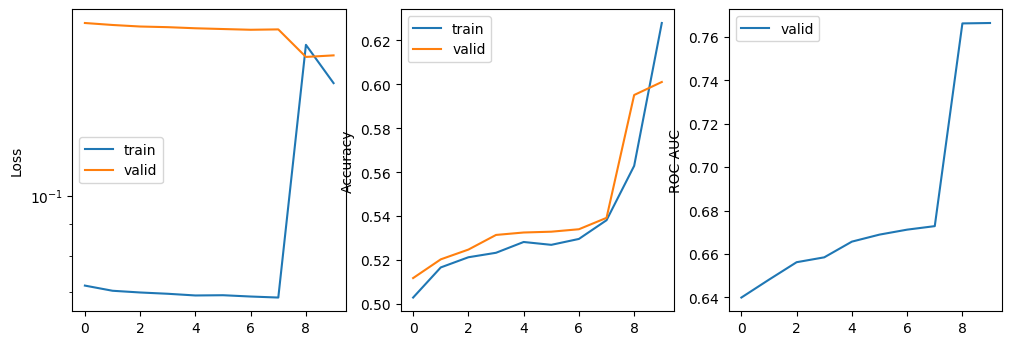

In [31]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
ax[0].plot(stats['train_loss'])
ax[0].plot(stats['valid_loss'])
ax[0].legend(['train', 'valid'])
ax[0].set_ylabel('Loss')
ax[0].set_yscale('log')

ax[1].plot(stats['train_acc'])
ax[1].plot(stats['valid_acc'])
ax[1].legend(['train', 'valid'])
ax[1].set_ylabel('Accuracy')

ax[2].plot(stats['val_rocauc'])
ax[2].legend(['valid'])
ax[2].set_ylabel('ROC AUC')

plt.savefig('../classifier_'+ datetime.now().strftime('%H-%d-%m-%Y')+'.png')
plt.show()

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

conf_matr = confusion_matrix(ytrue, np.round(np.asarray(ypred)), sample_weight=weight)

# predicted / True
print(conf_matr.astype('int'))

[[420 253]
 [192 602]]


In [33]:
# loader
valid_dataset = HatefulMemesDataset(data_valid, img_dir='../data',
                                    normalize=False, transform=Rescale(224, 2.))
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE_VALID, shuffle=False)

# TODO to calculate metrics
ypred = []
ytrue = []
weight = []

for step_num, batch in enumerate(valid_loader):
    # sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}        
    imgs = batch['image'].to(device)
    imgs = imgs.view(-1, 3, 224, 224)

    labels = batch['label'].to(device)
    masks = batch['mask'].to(device)
    token_ids = batch['token_id'].to(device)

    # account for class imbalance (66% label 0, 33% label 1)
    eye = torch.ones(labels.shape, device=device)
    weight_imbalance = (eye+ (labels==eye).int())* 0.63

    # loss
    logits = model(imgs.float(), token_ids, masks)

    batch_loss = weighted_binary_cross_entropy(logits, labels.float(), weight_imbalance)
    valid_loss += batch_loss.item()

    valid_correct += sum((torch.round(logits)==labels)*weight_imbalance).item()

    # ROC AUC
    ypred += logits.cpu().detach().numpy().reshape(-1).tolist()
    ytrue += labels.cpu().detach().numpy().reshape(-1).tolist()
    weight += weight_imbalance.cpu().detach().numpy().reshape(-1).tolist()
    
    '''
    #plots
    for i in range(BATCH_SIZE_VALID):
        if labels[i].item() != int(logits[i].item()):
            plt.figure()
            
            print(imgs[i].cpu().shape)
            plt.imshow(imgs[i].cpu().reshape(224,224,-1), cmap='gray')
            plt.title('Label '+ str(labels[i].cpu().item())+ ' Predicted '+ str(int(logits[i])))
            plt.show()
    '''

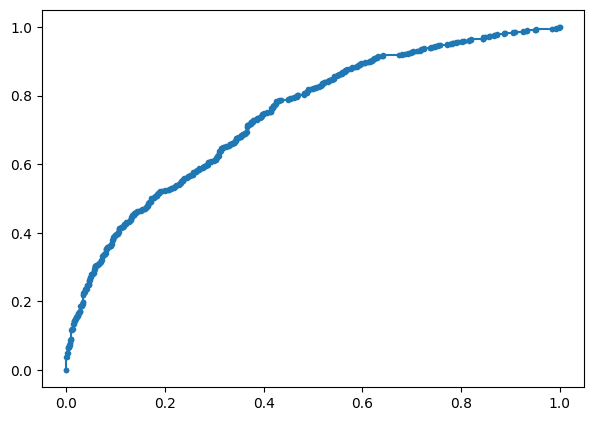

In [34]:
from sklearn.metrics import roc_curve

lr_fpr, lr_tpr, _ = roc_curve(ytrue, ypred)
# plot the roc curve for the model
plt.figure()
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.show()

## Predictions

In [35]:
# test data for competition
path_test = '../data/test.jsonl'

# read text
dataset_test = pd.read_json(path_test, lines=True)

# dictionary
data_test = dataset_test.to_dict(orient='records') # have been shuffled in previous step

# split into text (input) and labels (output)
test_texts, test_imgs, test_ids = list(zip(*map(lambda d: (d['text'], d['img'], d['id']), data_test)))
test_labels = np.zeros(len(test_ids)) # TODO: hack to use current implementation of Dataset class

print(len(test_texts))

# token embeddings with required separation token
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:token_length-2] + ['[SEP]'], test_texts))

# prepare token ids
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=token_length, truncating="post", padding="post", dtype="int")

# mask for padding -> required by bert
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

# put everything back into a dictionary
data_test = {'img_names': test_imgs, 'tokens': test_tokens, 'token_ids': test_tokens_ids,
              'masks': test_masks, 'labels': test_labels}

# test
test_dataset = HatefulMemesDataset(data_test, img_dir='../data',
                                    normalize=False, transform=composed) # TODO: I somehwere read that image models need 224x224 input
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

1000


In [36]:
print(test_ids[0])
#d4 = dict(d1, **d2)

16395


In [37]:
# prepare hand-in dataframe
proba = []
label = []

# validation
model.eval()
torch.cuda.empty_cache()

for step_num, batch in enumerate(test_loader):
    # sample = {'image': image, 'token_id': token_id, 'mask': mask, 'label': label}        
    imgs = batch['image'].to(device)
    imgs = imgs.view(-1, 3, 224, 224)

    masks = batch['mask'].to(device)
    token_ids = batch['token_id'].to(device)

    logits = model(imgs.float(), token_ids, masks)

    #
    proba += logits.cpu().detach().numpy().reshape(-1).tolist()
    label += torch.round(logits).cpu().detach().numpy().reshape(-1).tolist()
    
# 
#proba = np.round(np.asarray(proba), 2)
label = (np.asarray(label)).astype(int)


In [38]:
#
dictt = {'id': test_ids, 'proba': proba, 'label': label}

df = pd.DataFrame(data=dictt)

In [39]:
print(df)

        id     proba  label
0    16395  0.579998      1
1    37405  0.430332      0
2    94180  0.774975      1
3    54321  0.586939      1
4    97015  0.657999      1
..     ...       ...    ...
995   3869  0.148432      0
996  23817  0.540724      1
997  56280  0.295321      0
998  29384  0.338005      0
999  34127  0.731586      1

[1000 rows x 3 columns]


In [40]:
df.to_csv('../data/pred_'+datetime.now().strftime('%H-%d-%m-%Y'), index=False)